In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

from itertools import chain

from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import regex as re
from collections import namedtuple, defaultdict, Counter, OrderedDict
from IPython.display import display
from joblib import load, dump, Parallel, delayed

import os, string, sys

from gensim.models import word2vec

/home/entity/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/entity/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
class RegexFeatures(object):
    PATTERNS = {
        "isInitCapitalWord": re.compile(r'^[A-Z][a-z]+'),
        "isAllCapitalWord": re.compile(r'^[A-Z][A-Z]+$'),
        "isAllSmallCase": re.compile(r'^[a-z]+$'),
        "isWord": re.compile(r'^[a-zA-Z][a-zA-Z]+$'),
        "isAlphaNumeric": re.compile(r'^\p{Alnum}+$'),
        "isSingleCapLetter": re.compile(r'^[A-Z]$'),
        "containsDashes": re.compile(r'.*--.*'),
        "containsDash": re.compile(r'.*\-.*'),
        "singlePunctuation": re.compile(r'^\p{Punct}$'),
        "repeatedPunctuation": re.compile(r'^[\.\,!\?"\':;_\-]{2,}$'),
        "singleDot": re.compile(r'[.]'),
        "singleComma": re.compile(r'[,]'),
        "singleQuote": re.compile(r'[\']'),
        "isSpecialCharacter": re.compile(r'^[#;:\-/<>\'\"()&]$'),
        "fourDigits": re.compile(r'^\d\d\d\d$'),
        "isDigits": re.compile(r'^\d+$'),
        "isNumber": re.compile(r'^((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
        "containsDigit": re.compile(r'.*\d+.*'),
        "endsWithDot": re.compile(r'\p{Alnum}+\.$'),
        "isURL": re.compile(r'^http[s]?://'),
        "isMention": re.compile(r'^(RT)?@\p{Alnum}+$'),
        "isHashtag": re.compile(r'^#\p{Alnum}+$'),
        "isMoney": re.compile(r'^\$((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
    }
    def __init__(self):
        print "Initialized RegexFeature"
    @staticmethod
    def process(word):
        features = dict()
        for k, p in RegexFeatures.PATTERNS.iteritems():
            if p.match(word):
                features[k] = True
        return features
    
    
def classification_report_to_df(report):
    report_list = []
    for i, line in enumerate(report.split("\n")):
        if i == 0:
            report_list.append(["class", "precision", "recall", "f1-score", "support"])
        else:
            line = line.strip()
            if line:
                if line.startswith("avg"):
                    line = line.replace("avg / total", "avg/total")
                line = re.split(r'\s+', line)
                report_list.append(tuple(line))
    return pd.DataFrame(report_list[1:], columns=report_list[0])


DATA_DIR="data/data/"
CLEANED_DIR="data/cleaned/"

Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False, test_data=False):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                if test_data:
                    assert len(line) == 1
                    line.append("?")
                if notypes:
                    line[1] = line[1][0]
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences


def load_vocab(filename):
    vocab = set()
    with open(filename) as fp:
        for line in fp:
            line = line.strip()
            vocab.add(line)
    return vocab      

    
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
        
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr)) 
        
        
def plot_cm(y_test, y_pred, labels=[]):
    labels_s = dict((k,i) for i,k in enumerate(labels))
    cm = np.zeros((len(labels), len(labels)))
    for i,j in zip(sum(y_test, []), sum(y_pred, [])):
        i = labels_s[i]
        j = labels_s[j]
        cm[i,j] += 1
    with plt.rc_context(rc={'xtick.labelsize': 12, 'ytick.labelsize': 12,
                       'figure.figsize': (16,14)}):
        sns.heatmap(cm * 100/ cm.sum(axis=1, keepdims=True),
                    #cmap=sns.cubehelix_palette(n_colors=100, rot=-.4, as_cmap=True),
                    cmap="Greys_r",
                    xticklabels=labels,
                    yticklabels=labels)
        plt.ylabel("True labels")
        plt.xlabel("Predicted labels")
    print cm.shape
    return cm


def print_sequences(sequences, predictions, filename, test_data=False):
    with open(filename, "wb+") as fp:
        for seq, pred in zip(sequences, predictions):
            for t, p in zip(seq, pred):
                token, tag = t
                if tag[0] == "U":
                    tag = "B%s" % tag[1:]
                if tag[0] == "E":
                    tag = "I%s" % tag[1:]
                if p[0] == "U":
                    p = "B%s" % p[1:]
                if p[0] == "E":
                    p = "I%s" % p[1:]
                if test_data:
                    line = "\t".join((token, p))
                else:
                    line = "\t".join((token, tag, p))
                print >> fp, line
            print >> fp, ""
    print "Done"

In [3]:
WORD_SPLITTER = re.compile(r'[\p{Punct}\s]+')
class DictionaryFeatures:
    def __init__(self, dictDir):
        self.word2dictionaries = {}
        self.word2hashtagdictionaries = {}
        self.dictionaries = []
        i = 0
        for d in os.listdir(dictDir):
            print >> sys.stderr, "read dict %s"%d
            self.dictionaries.append(d)
            if d == '.svn':
                continue
            for line in open(dictDir + "/" + d):
                word = line.rstrip('\n')
                word = word.strip(' ').lower()
                word_hashtag = "".join(WORD_SPLITTER.split(word))
                if not self.word2dictionaries.has_key(word):
                    self.word2dictionaries[word] = str(i)
                else:   
                    self.word2dictionaries[word] += "\t%s" % i
                if not self.word2hashtagdictionaries.has_key(word_hashtag):
                    self.word2hashtagdictionaries[word_hashtag] = str(i)
                else:
                    self.word2hashtagdictionaries[word_hashtag] += "\t%s" % i
            i += 1
    
    MAX_WINDOW_SIZE=6
    def GetDictFeatures(self, words, i):
        features = []
        for window in range(1,self.MAX_WINDOW_SIZE):
            start=max(i-window+1, 0)
            end = start + window
            phrase = ' '.join(words[start:end]).lower().strip(string.punctuation)
            if self.word2dictionaries.has_key(phrase):
                for j in self.word2dictionaries[phrase].split('\t'):
                    features.append('DICT=%s' % self.dictionaries[int(j)])
                if window > 1:
                    features.append('DICTWIN=%s' % window)
        return list(set(features))
    
    def GetHashtagDictFeatures(self, word):
        features = []
        if len(word) < 2 or word[0] != "#":
            return features
        word = word[1:].lower().strip(string.punctuation)
        if self.word2hashtagdictionaries.has_key(word):
            for j in self.word2hashtagdictionaries[word].split('\t'):
                features.append('DICT_HASHTAG=%s' % self.dictionaries[int(j)])
        return list(set(features))


In [4]:
train_sequences = load_sequences("data/cleaned/train.BIEOU.tsv", sep="\t", notypes=False)
dev_sequences = (load_sequences("data/cleaned/dev.BIEOU.tsv", sep="\t", notypes=False) 
                 + load_sequences("data/cleaned/dev_2015.BIEOU.tsv", sep="\t", notypes=False))
test_sequences = load_sequences("data/cleaned/test.BIEOU.tsv", sep="\t", notypes=False)
vocab = load_vocab("vocab.no_extras.txt")
print len(vocab)

8023


{'product': 5, 'facility': 4, 'movie': 8, 'company': 3, 'sportsteam': 7, 'musicartist': 6, 'person': 1, 'other': 2, 'geo-loc': 0, 'tvshow': 9}
Counter({'geo-loc': 1323, 'person': 1180, 'other': 995, 'company': 865, 'facility': 404, 'product': 390, 'musicartist': 304, 'sportsteam': 303, 'movie': 86, 'tvshow': 75})


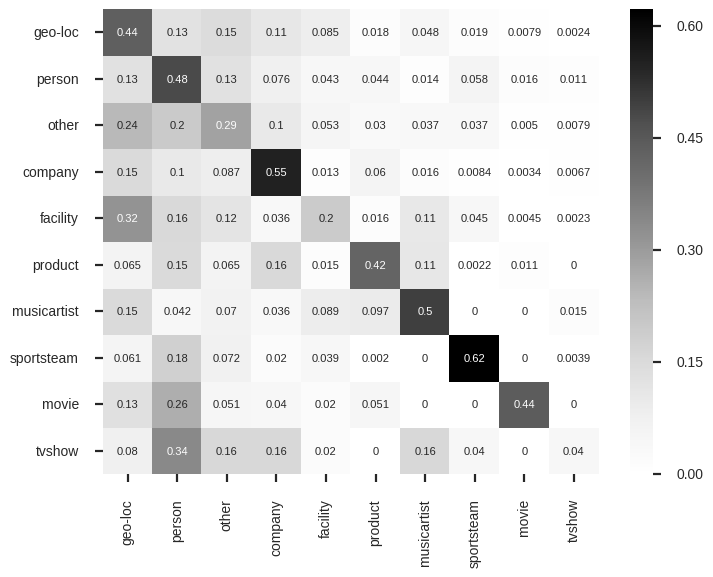

In [5]:
label_co_occurences = [[t[1][2:] for t in seq if t[1][0] in ["B", "U"]] 
                       for seq in (train_sequences+dev_sequences+test_sequences)]

cat_types = Counter(t for seq in label_co_occurences for t in seq)
cat_ids = {k[0]: i for i, k in enumerate(cat_types.most_common())}
cat_names = [k[0] for k in cat_types.most_common()]
print cat_ids
print cat_types
co_occur_matrix = np.zeros((len(cat_ids), len(cat_ids)))
for seq in label_co_occurences:
    for i, t in enumerate(seq):
        for j, t1 in enumerate(seq):
            if i != j:
                co_occur_matrix[cat_ids[t], cat_ids[t1]] += 1
for k,i in cat_ids.iteritems():
    co_occur_matrix[cat_ids[k]] /= co_occur_matrix[cat_ids[k]].sum()
    
#print co_occur_matrix
    
with plt.rc_context(rc={'xtick.labelsize': 10, 'ytick.labelsize': 10,
                        'font.size': 8,
                       'figure.figsize': (8,6)}):
    sns.heatmap(co_occur_matrix, xticklabels=cat_names, yticklabels=cat_names, annot=True, cmap="Greys")

Num entities in Training data (N=2394, N_entities=1499, N(no-entities)=1476): min=0, max=6, median=0.0, mean(+/-std)=0.6 +/- 1.0
Num entities in Development data (N=1420, N_entities=937, N(no-entities)=838): min=0, max=9, median=0.0, mean(+/-std)=0.7 +/- 1.0
Num entities in Test data (N=3856, N_entities=3489, N(no-entities)=1842): min=0, max=11, median=1.0, mean(+/-std)=0.9 +/- 1.1


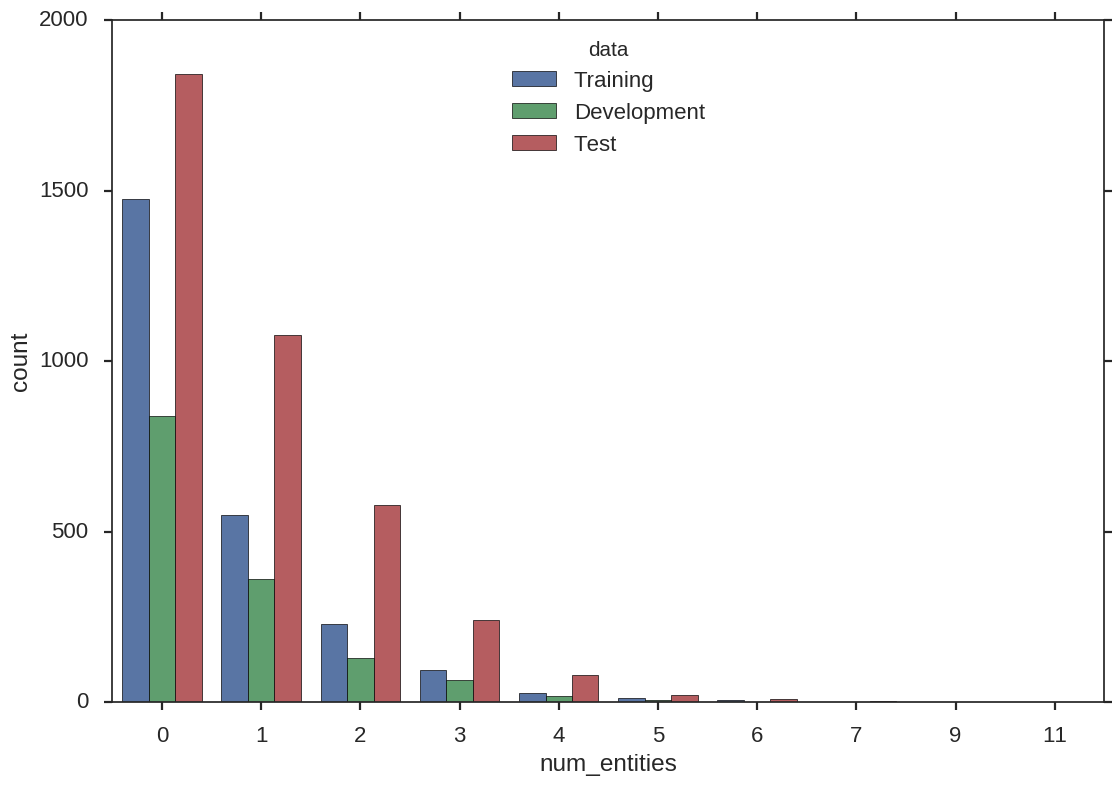

In [6]:
total_lens = []
for sequences, label in zip((train_sequences, dev_sequences, test_sequences),
                       ("Training", "Development", "Test")):
    lens = [len([t[1][2:] for t in seq if t[1][0] in ["B", "U"]])
                       for seq in (sequences)]
    total_lens.extend([(t, label) for t in lens])
    print "Num entities in {} data (N={}, N_entities={}, N(no-entities)={}): min={}, max={}, median={}, mean(+/-std)={:.1f} +/- {:.1f}".format(
        label, len(lens), sum(lens), len(filter(lambda x: x==0, lens)),
        min(lens), max(lens), np.median(lens), np.mean(lens), np.std(lens))
sns.countplot(x="num_entities", hue="data", data=pd.DataFrame(total_lens, columns=["num_entities", "data"]))

In [7]:
len(filter(lambda x: x==0, lens))

1842

In [8]:
sns.__version__

'0.7.1'

Entity length in Training data (N=1499, N_entities=2462): min=1, max=10, median=1.0, mean(+/-std)=1.6 +/- 1.0
Entity length in Development data (N=937, N_entities=1567): min=1, max=14, median=1.0, mean(+/-std)=1.7 +/- 1.2
Entity length in Test data (N=3489, N_entities=5955): min=1, max=14, median=1.0, mean(+/-std)=1.7 +/- 1.2


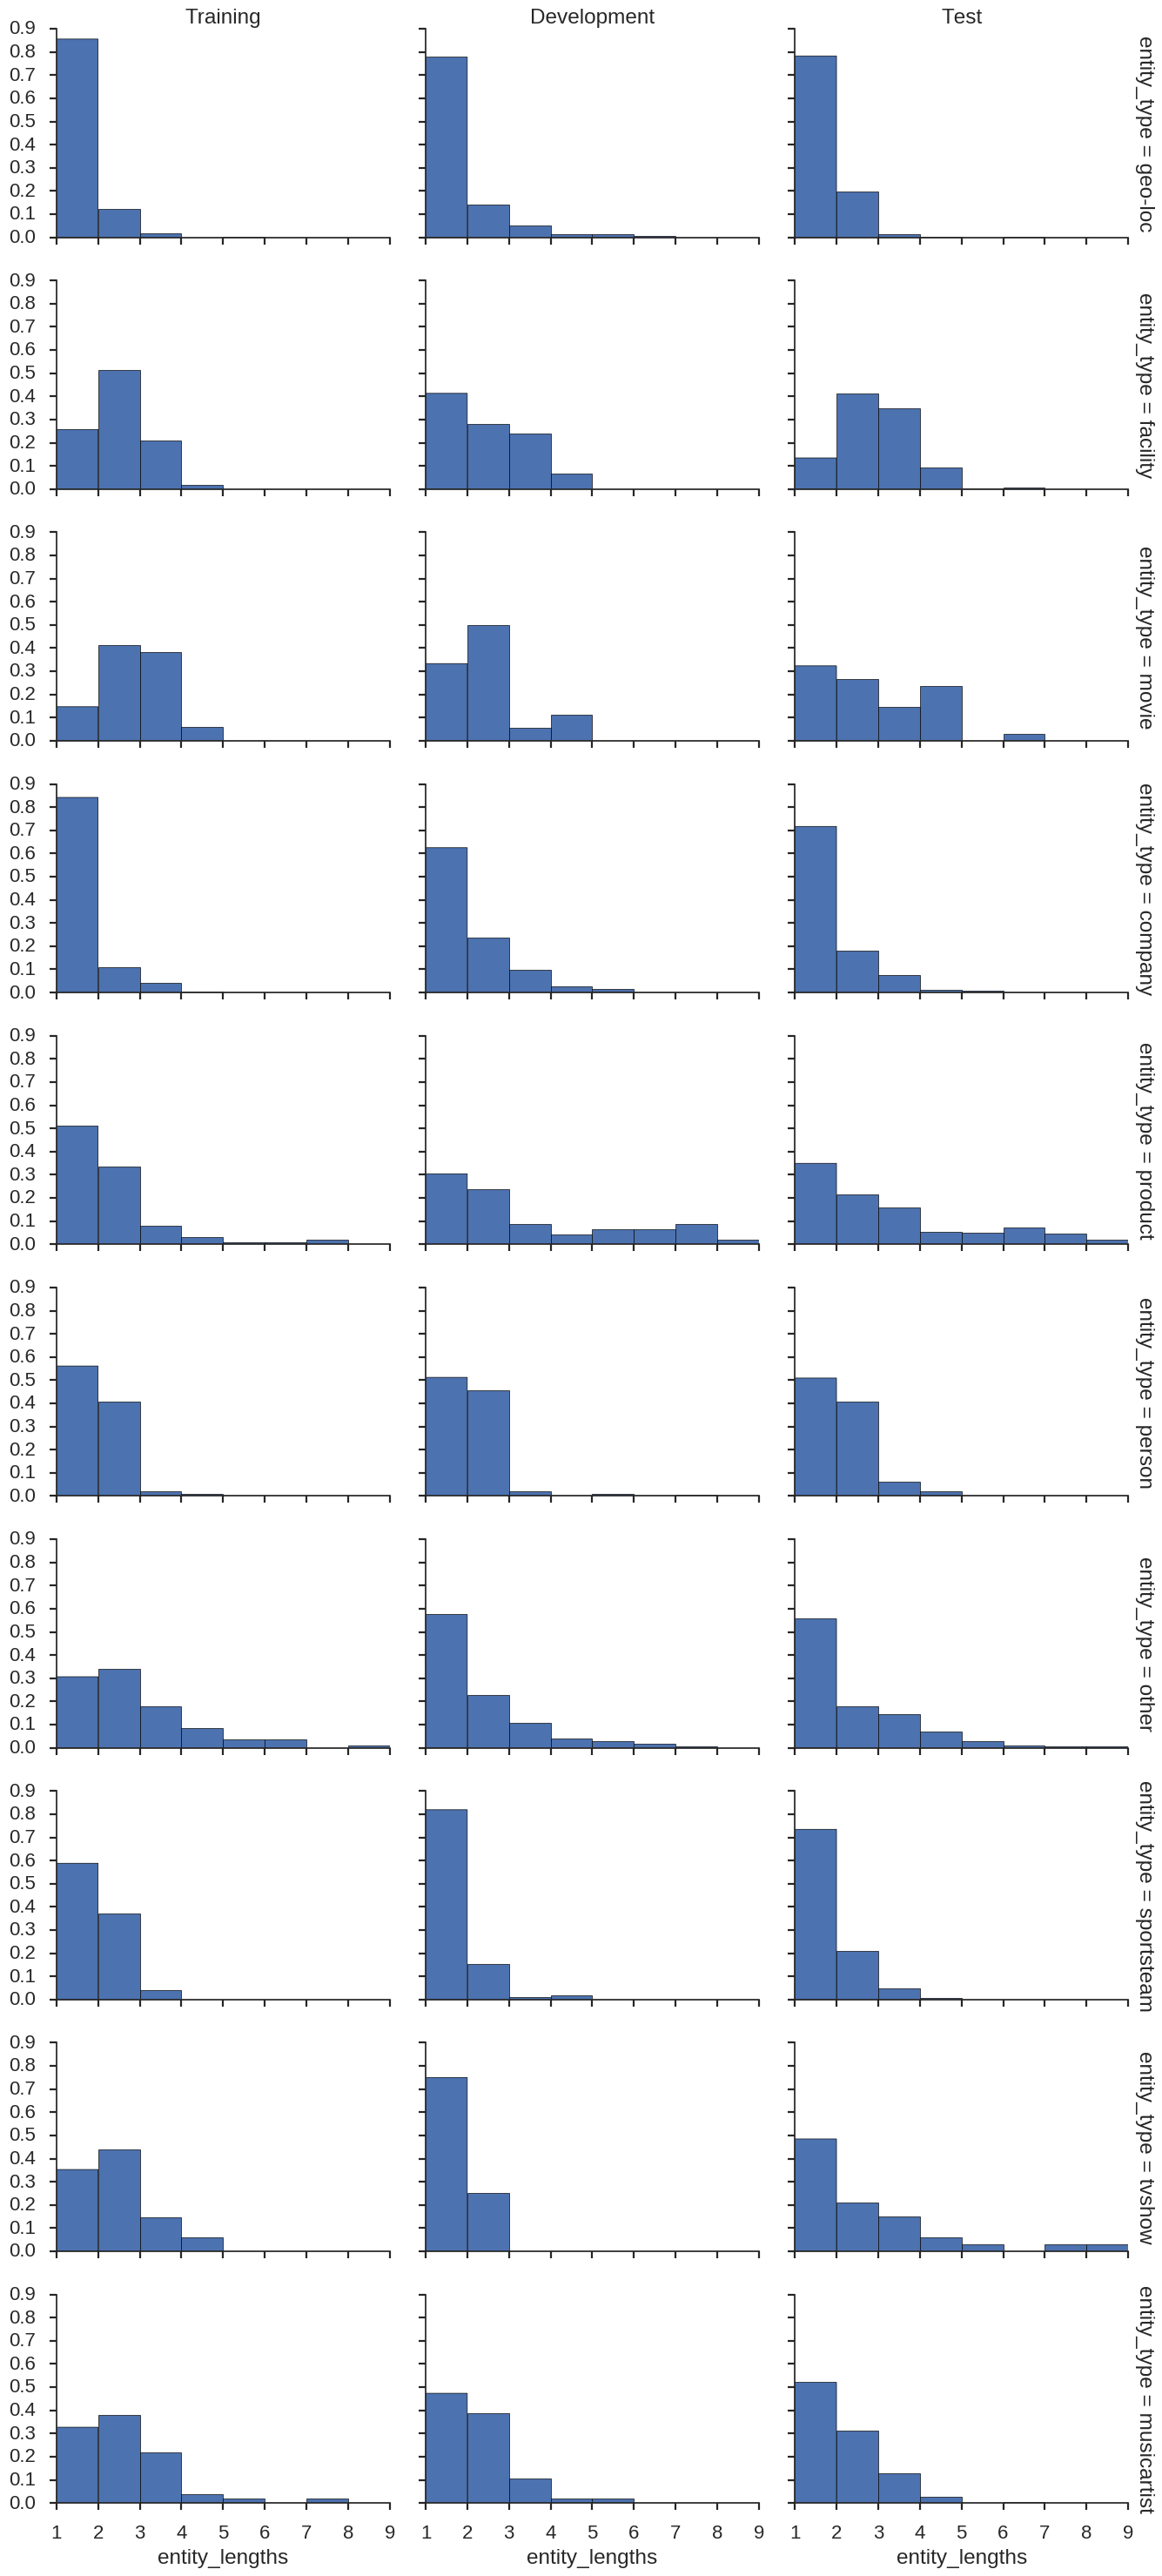

In [9]:
total_lens = []
for sequences, label in zip((train_sequences, dev_sequences, test_sequences),
                       ("Training", "Development", "Test")):
    lens = []
    for seq in sequences:
        e_length=0
        e_type=None
        for t in seq:
            if t[1][0] == "O":
                continue
            if t[1][0] in {"B", "U"}:
                if e_length > 0:
                    lens.append((e_length, e_type))
                e_length=0
                e_type=t[1][2:]
            e_length += 1
        if e_length > 0:
            lens.append((e_length, e_type))
    total_lens.extend([t+(label,) for t in lens])
    lens = [t[0] for t in lens]
    print "Entity length in {} data (N={}, N_entities={}): min={}, max={}, median={}, mean(+/-std)={:.1f} +/- {:.1f}".format(
        label, len(lens), sum(lens), min(lens), max(lens), np.median(lens), np.mean(lens), np.std(lens))

def plot_data(x, **kwargs):
    weights = np.ones_like(x)*1./len(x)
    return plt.hist(x, weights=weights, **kwargs)
g = (sns.FacetGrid(row="entity_type", col="data", aspect=1.5, margin_titles=True,
                  data=pd.DataFrame(total_lens, columns=["entity_lengths", "entity_type", "data"])))
g = g.map(plot_data, "entity_lengths", bins=range(1,10))
g = g.set_titles(template="", col_template="{col_name}")
g.fig.tight_layout()

['person', 'geo-loc', 'other', 'company', 'facility', 'product', 'musicartist', 'sportsteam', 'movie', 'tvshow']
Training sequences: 2394
Development sequences: 1420


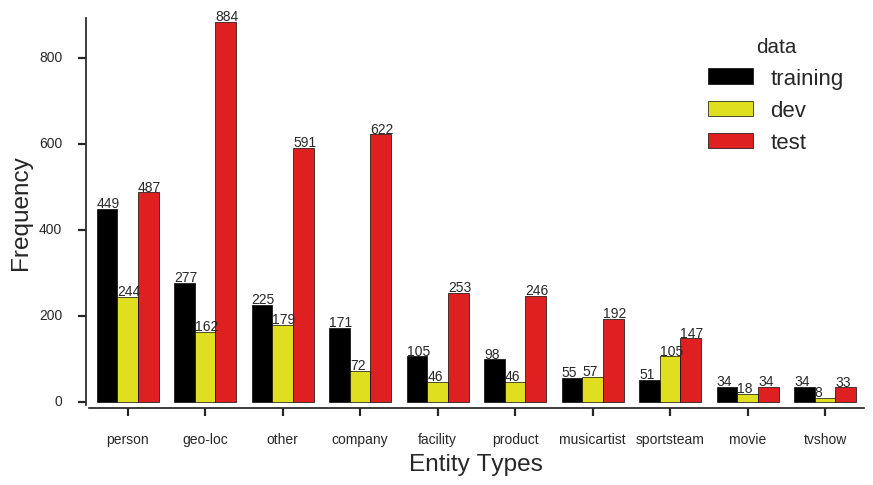

In [32]:
phrase_types_training = [(t[1][2:], "training") for seq in (train_sequences) for t in seq if t[1][0] in ["B", "U"]]
phrase_types_dev = [(t[1][2:], "dev") for seq in (dev_sequences) for t in seq if t[1][0] in ["B", "U"]]
phrase_types_test = [(t[1][2:], "test") for seq in (test_sequences) for t in seq if t[1][0] in ["B", "U"]]
df_t = pd.DataFrame(phrase_types_training+phrase_types_dev+phrase_types_test, columns=["phrase_type", "data"])
cat_names = [k[0] for k,v in Counter(phrase_types_training).most_common()]
print cat_names
#palette = ["0.2", "0.5", "0.7"]
palette = ["black", "yellow", "red"]
with plt.rc_context(rc={'xtick.labelsize': 10, 'ytick.labelsize': 10,
                        'font.size': 10,
                       'figure.figsize': (10,5)}):
    ax = sns.countplot(x="phrase_type", hue="data", data=df_t,
                       palette=palette, order=cat_names)
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
    plt.xlabel("Entity Types")
    plt.ylabel("Frequency")
    plt.margins(0.01)
    sns.despine(offset=2)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x(), height+3, '%.0f'%(height))
        
print "Training sequences: {}".format(len(train_sequences))
print "Development sequences: {}".format(len(dev_sequences))
df_t.data.value_counts()
plt.savefig("Data.tiff", bbox_inches="tight")

In [11]:
lens[:10]

[6, 1, 2, 1, 1, 1, 2, 3, 1, 9]

In [12]:
phrase_types_test[:10]

[('other', 'test'),
 ('movie', 'test'),
 ('person', 'test'),
 ('person', 'test'),
 ('geo-loc', 'test'),
 ('person', 'test'),
 ('company', 'test'),
 ('company', 'test'),
 ('geo-loc', 'test'),
 ('product', 'test')]

In [13]:
train_lens = [len(seq) for seq in train_sequences]
dev_lens = [len(seq) for seq in dev_sequences]
test_lens = [len(seq) for seq in test_sequences]
for lens, label in zip((train_lens, dev_lens, test_lens),
                       ("Training", "Development", "Test")):
    print "{0} lengths: {1:.1f} +/- {2:.1f}".format(
        label, np.mean(lens), np.std(lens))

Training lengths: 19.4 +/- 7.6
Development lengths: 16.2 +/- 6.8
Test lengths: 16.1 +/- 6.6


In [14]:
for sequences, label in zip((train_sequences, dev_sequences, test_sequences),
                       ("Training", "Development", "Test")):
    phrase_counts = [len([t[1][2:] for t in seq if t[1][0] in ["B", "U"]])
                       for seq in (sequences)]
    print "{} phrase counts: {} - {}".format(label,
        np.min(phrase_counts), np.max(phrase_counts))

Training phrase counts: 0 - 6
Development phrase counts: 0 - 9
Test phrase counts: 0 - 11


In [15]:
data = """F	MF	+GZ	+WRG	+WCBPT	+WCCC	+WRFTC	+GF	+RSFD	ST	BL
10-types	5.32	34.8	36.66	41.59	41.04	43.3	40.94		36.22	35.1
company	0	30	34.53	33.33	35.2	33.33	32		27.72	26.17
facility	0	12.35	9.62	20.78	18.56	17.91	14.49		30.38	19.15
geo-loc	5.24	47.21	48.06	53.83	54.4	55.93	56.73		49.71	48.36
movie	8	7.41	6.45	8.33	7.69	9.52	23.53		8.33	0
musicartist	0	6.56	8.45	9.09	9.52	12.7	6.45		0	0
other	5.79	18.56	18.69	22.54	20.85	26.63	22.11		24.16	27.74
person	11.37	55.07	58.51	63.39	63.81	64.82	64.96		53.36	50.18
product	2.92	12.66	20	16.67	18.18	15.38	10.75		8.96	11.9
sportsteam	0	12.9	27.94	30.53	29.01	28.13	27.69		12.8	13.11
tvshow	0	0	0	16.67	16.67	16.67	18.18		0	14.29
No-types	13.13	48.31	52.51	56.73	56.41	57.38	53.67		50.53	51.71"""

In [16]:
df_t = pd.DataFrame([[t.strip() for t in line.split("\t")] for line in data.split("\n")[1:]])
#df_t.columns = data.split("\n")[0].split()
df_t.columns

RangeIndex(start=0, stop=11, step=1)

In [17]:
len(data.split("\n")[0].split("\t"))

11

In [18]:
df_t.shape

(12, 11)

In [19]:
df_t.columns = data.split("\n")[0].split("\t")
df_t

,F,MF,+GZ,+WRG,+WCBPT,+WCCC,+WRFTC,+GF,+RSFD,ST,BL
0,10-types,5.32,34.8,36.66,41.59,41.04,43.3,40.94,,36.22,35.1
1,company,0,30,34.53,33.33,35.2,33.33,32,,27.72,26.17
2,facility,0,12.35,9.62,20.78,18.56,17.91,14.49,,30.38,19.15
3,geo-loc,5.24,47.21,48.06,53.83,54.4,55.93,56.73,,49.71,48.36
4,movie,8,7.41,6.45,8.33,7.69,9.52,23.53,,8.33,0
5,musicartist,0,6.56,8.45,9.09,9.52,12.7,6.45,,0,0
6,other,5.79,18.56,18.69,22.54,20.85,26.63,22.11,,24.16,27.74
7,person,11.37,55.07,58.51,63.39,63.81,64.82,64.96,,53.36,50.18
8,product,2.92,12.66,20,16.67,18.18,15.38,10.75,,8.96,11.9
9,sportsteam,0,12.9,27.94,30.53,29.01,28.13,27.69,,12.8,13.11


In [20]:
df_t[df_t["F"] == "10-types"]

,F,MF,+GZ,+WRG,+WCBPT,+WCCC,+WRFTC,+GF,+RSFD,ST,BL
0,10-types,5.32,34.8,36.66,41.59,41.04,43.3,40.94,,36.22,35.1


In [21]:
df_t=df_t.set_index("F")
df_t

,MF,+GZ,+WRG,+WCBPT,+WCCC,+WRFTC,+GF,+RSFD,ST,BL
F,,,,,,,,,,
10-types,5.32,34.8,36.66,41.59,41.04,43.3,40.94,,36.22,35.1
company,0,30,34.53,33.33,35.2,33.33,32,,27.72,26.17
facility,0,12.35,9.62,20.78,18.56,17.91,14.49,,30.38,19.15
geo-loc,5.24,47.21,48.06,53.83,54.4,55.93,56.73,,49.71,48.36
movie,8,7.41,6.45,8.33,7.69,9.52,23.53,,8.33,0
musicartist,0,6.56,8.45,9.09,9.52,12.7,6.45,,0,0
other,5.79,18.56,18.69,22.54,20.85,26.63,22.11,,24.16,27.74
person,11.37,55.07,58.51,63.39,63.81,64.82,64.96,,53.36,50.18
product,2.92,12.66,20,16.67,18.18,15.38,10.75,,8.96,11.9


In [22]:
df_t = df_t.drop("+RSFD", axis=1)
df_t

,MF,+GZ,+WRG,+WCBPT,+WCCC,+WRFTC,+GF,ST,BL
F,,,,,,,,,
10-types,5.32,34.8,36.66,41.59,41.04,43.3,40.94,36.22,35.1
company,0,30,34.53,33.33,35.2,33.33,32,27.72,26.17
facility,0,12.35,9.62,20.78,18.56,17.91,14.49,30.38,19.15
geo-loc,5.24,47.21,48.06,53.83,54.4,55.93,56.73,49.71,48.36
movie,8,7.41,6.45,8.33,7.69,9.52,23.53,8.33,0
musicartist,0,6.56,8.45,9.09,9.52,12.7,6.45,0,0
other,5.79,18.56,18.69,22.54,20.85,26.63,22.11,24.16,27.74
person,11.37,55.07,58.51,63.39,63.81,64.82,64.96,53.36,50.18
product,2.92,12.66,20,16.67,18.18,15.38,10.75,8.96,11.9


In [23]:
df_t = df_t.astype("float")

In [24]:
pd.DataFrame(df_t.ix["10-types"])

,10-types
MF,5.32
+GZ,34.80
+WRG,36.66
+WCBPT,41.59
+WCCC,41.04
+WRFTC,43.30
+GF,40.94
ST,36.22
BL,35.10


In [25]:
df_tt = pd.DataFrame(df_t.ix["10-types"])

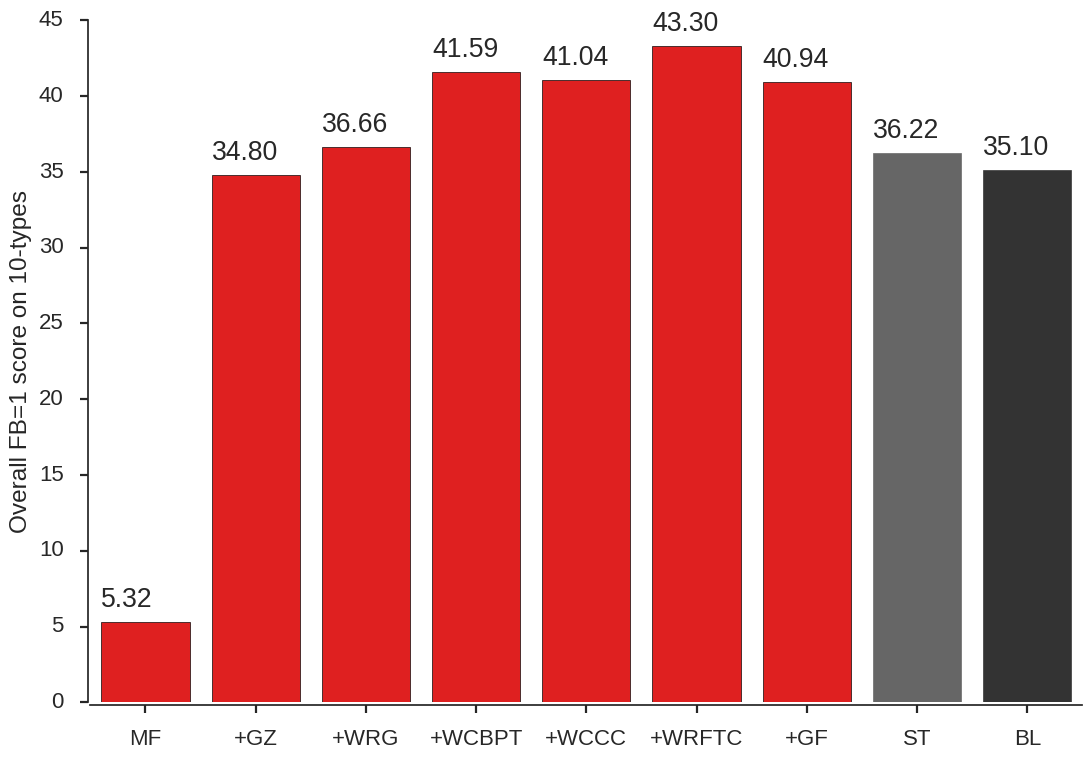

In [26]:
ax = sns.barplot(y="10-types", x=df_tt.index, data=df_tt, color="red")
sns.despine(offset=2)
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x(), height+1, '%.2f'%(height))
        
ax.patches[-2].set_color("0.4")
p.set_color("0.2")
ax.set_ylabel("Overall FB=1 score on 10-types")

        